## Setup

In [43]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

def build_EIANN_from_config(config_path, network_seed=42):
    '''
    Build an EIANN network from a config file
    '''
    network_config = ut.read_from_yaml(config_path)
    layer_config = network_config['layer_config']
    projection_config = network_config['projection_config']
    training_kwargs = network_config['training_kwargs']
    network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)
    return network


# Load dataset
tensor_flatten = T.Compose([T.ToTensor(), T.Lambda(torch.flatten)])
MNIST_train_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/', train=True, download=False,
                                         transform=tensor_flatten)
MNIST_test_dataset = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',
                                        train=False, download=False,
                                        transform=tensor_flatten)

# Add index to train & test data
MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train_dataset):
    target = torch.eye(len(MNIST_train_dataset.classes))[target]
    MNIST_train.append((idx, data, target))
    
MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test_dataset):
    target = torch.eye(len(MNIST_test_dataset.classes))[target]
    MNIST_test.append((idx, data, target))
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(MNIST_train[0:50_000], batch_size=50_000)
train_sub_dataloader = torch.utils.data.DataLoader(MNIST_train[0:1000], shuffle=True, generator=data_generator, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(MNIST_train[-10_000:], batch_size=10_000, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(MNIST_test, batch_size=10_000, shuffle=False)

epochs = 1
data_seed = 0
network_seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## bpDale angle comparison

In [298]:
# Build network
config_path = "../config/MNIST/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G.yaml"
saved_network_path = "../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl"

# config_path = "../config/MNIST/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G2.yaml"
# saved_network_path = 'saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps2.pkl'

bpDale_network = build_EIANN_from_config(config_path, network_seed=42)

# data_generator.manual_seed(data_seed)
# bpDale_network.train(train_dataloader, 
#                     test_dataloader, 
#                     epochs=epochs,
#                     val_interval=(0,-1,100),
#                     samples_per_epoch=20000,
#                     store_history=True, 
#                     store_params=True,
#                     status_bar=True)
# bpDale_network.save(path=saved_network_path)

bpDale_network.load(saved_network_path)

Loading model data from '../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'...
Loading parameters into the network...
Model successfully loaded from '../optimize/data/mnist/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps.pkl'


In [299]:
# pt.plot_batch_accuracy(bpDale_network, test_dataloader)

In [300]:
def recursive_dict_rename(my_dict, old_name, new_name):
    for key in list(my_dict):
        if key == old_name:
            my_dict[new_name] = my_dict.pop(old_name)
        elif isinstance(my_dict[key], dict):
            recursive_dict_rename(my_dict[key], old_name, new_name)
    return 

def rename_population(network, old_name, new_name):
    recursive_dict_rename(network.__dict__, old_name, new_name)

    # Rename populations in module_dict
    for key in list(network.module_dict):
        post_pop, pre_pop = key.split('_')

        for layer_name in list(network.layers):
            if pre_pop.startswith(layer_name):
                pre_pop_name = pre_pop[len(layer_name):]
                if pre_pop_name == old_name:
                    pre_pop = layer_name+new_name
            if post_pop.startswith(layer_name):
                post_pop_name = post_pop[len(layer_name):]
                if post_pop_name == old_name:
                    post_pop = layer_name+new_name
        new_key = f'{post_pop}_{pre_pop}'
        if new_key != key:
            network.module_dict[new_key] = network.module_dict.pop(key)

    # Rename populations in parameter_dict
    for key in list(network.parameter_dict):
        pop_fullname, param_name = key.split('_')

        for layer_name in list(network.layers):
            if pop_fullname.startswith(layer_name):
                pop_name = pop_fullname[len(layer_name):]
                if pop_name == old_name:
                    pop_fullname = layer_name+new_name
        new_key = f'{pop_fullname}_{param_name}'
        if new_key != key:
            network.parameter_dict[new_key] = network.parameter_dict.pop(key)

    # Rename populations in layers and projections
    for layer in network:
        recursive_dict_rename(layer.__dict__, old_name, new_name)
        for population in layer:
            if population.name == old_name:
                population.name = new_name
                population.fullname = layer.name+new_name
            recursive_dict_rename(population.__dict__, old_name, new_name)

            for projection in population:
                projection.name = f'{projection.post.layer.name}{projection.post.name}_{projection.pre.layer.name}{projection.pre.name}'


# rename_population(bpDale_network, 'I', 'SomaI')
# bpDale_network.save('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps2.pkl')

In [301]:
# pt.plot_loss_landscape(test_dataloader, bpDale_network)

In [310]:
# bpClone_network = ut.compute_alternate_dParam_history(train_dataloader, bpDale_network, save_path='saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')
# rename_population(bpClone_network, 'I', 'SomaI')
# bpClone_network.save('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

config_path = "../config/MNIST/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G2.yaml"
bpClone_network = build_EIANN_from_config(config_path, network_seed=42)
bpClone_network.load('saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl')

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl
Model saved to saved_networks/20230815_EIANN_1_hidden_mnist_bpDale_softplus_SGD_config_G_66049_257_20000_steps_bpClone.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # *******************************************************************


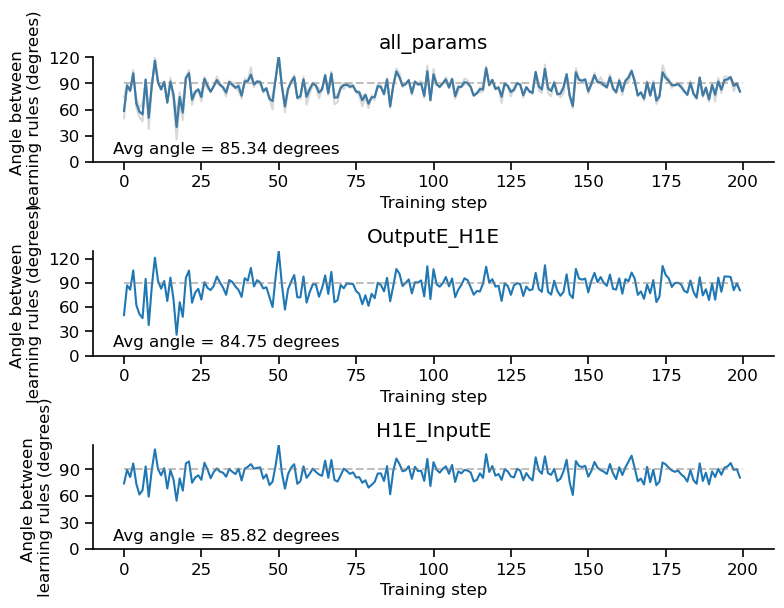

In [311]:
angles = ut.compute_dW_angles(bpClone_network, plot=True)

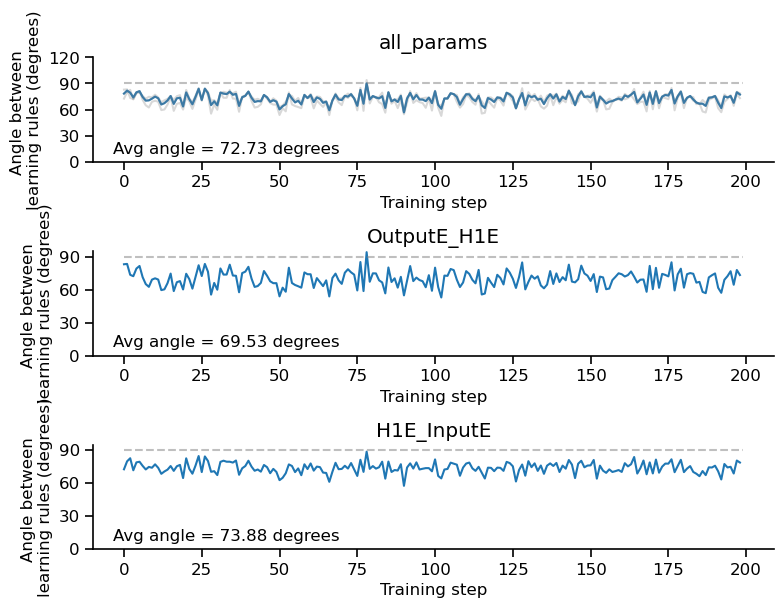

In [312]:
angles = ut.compute_dW_angles(bpClone_network, plot=True, step_averaged=True)

## BTSP angle comparison

In [313]:
# Build network
config_path = "../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml"
btsp_network = build_EIANN_from_config(config_path, network_seed=42)

saved_network_path = "../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl"
btsp_network.load(saved_network_path)

Loading model data from '../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl'...
Loading parameters into the network...
Model successfully loaded from '../optimize/data/mnist/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps.pkl'


In [314]:
config_path = "../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml"
btsp_bpClone = build_EIANN_from_config(config_path, network_seed=42)
saved_network_path = 'saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpClone.pkl'
btsp_bpClone.load(saved_network_path)

# btsp_bpClone = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpClone.pkl')

  0%|          | 0/200 [00:00<?, ?it/s]

Model saved to saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_bpClone.pkl


/Users/ag1880/Github_repos/Milstein-Lab/EIANN/EIANN/utils.py:1251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # *******************************************************************


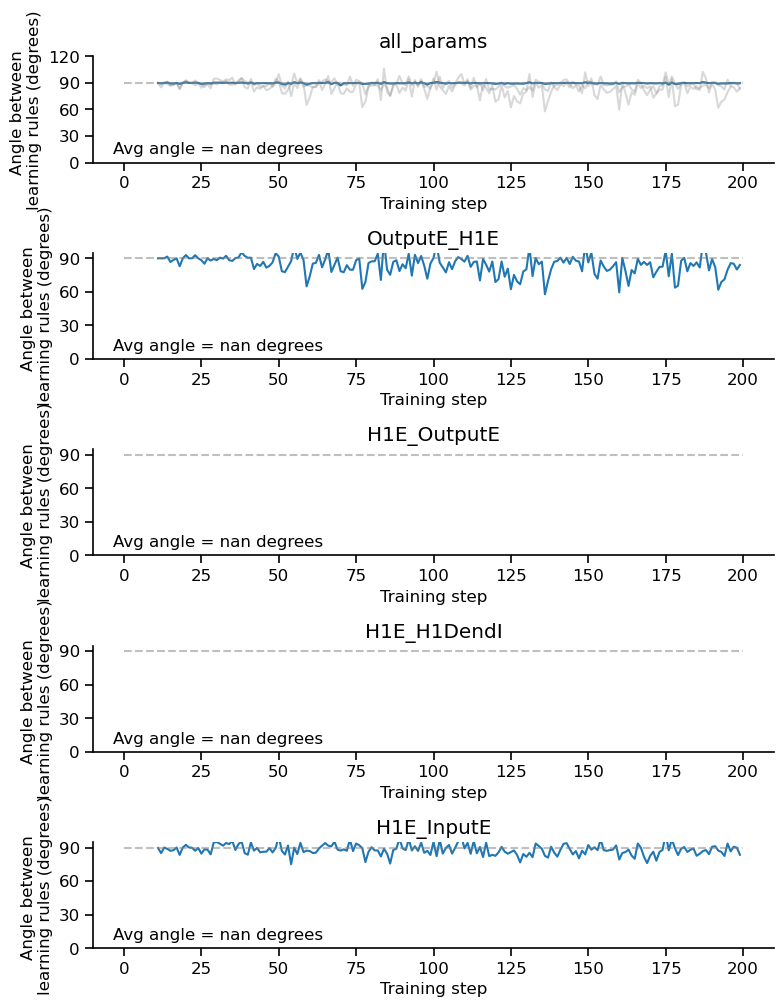

In [315]:
angles = ut.compute_dW_angles(btsp_bpClone, plot=True)

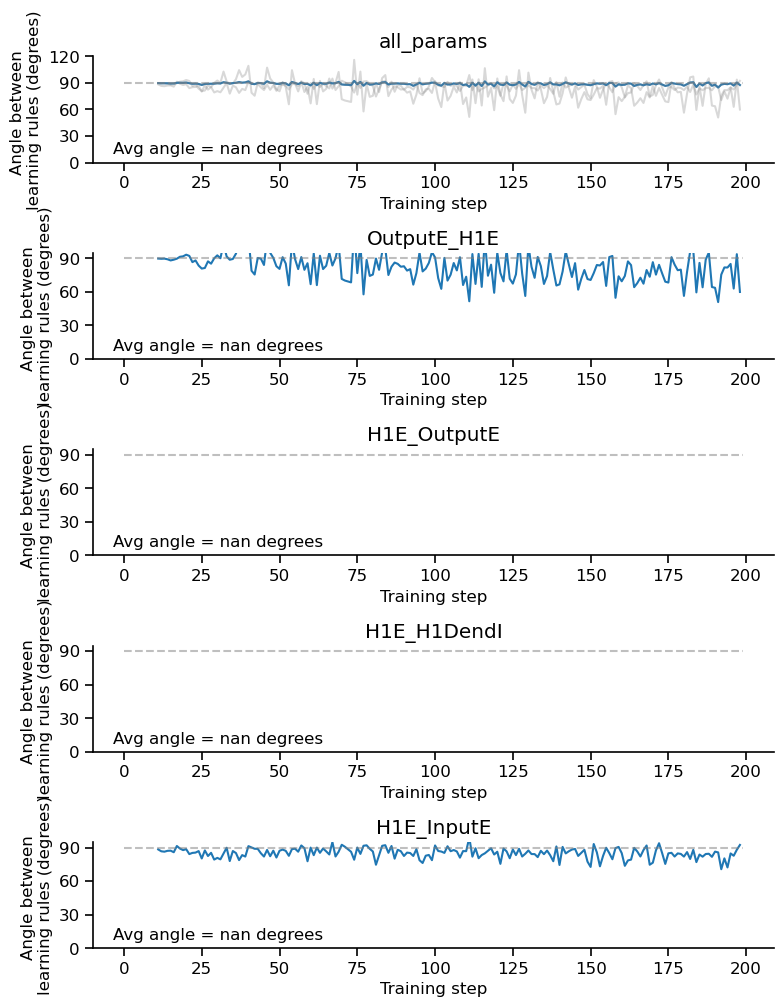

In [316]:
angles = ut.compute_dW_angles(btsp_bpClone, plot=True, step_averaged=True)

In [324]:
btsp_comparison_network.H1.populations['DendI'].fullname

'H1DendI'

In [317]:
# btsp_comparison_network = ut.compute_alternate_dParam_history(train_dataloader, btsp_network, bpDale_network, save_path='saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_comparison.pkl')

config_path = "../config/MNIST/20230822_EIANN_1_hidden_mnist_BTSP_config_G3.yaml"
btsp_comparison_network = build_EIANN_from_config(config_path, network_seed=42)
saved_network_path = 'saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_comparison.pkl'
btsp_comparison_network.load(saved_network_path)

Loading model data from 'saved_networks/20230822_EIANN_1_hidden_mnist_BTSP_config_G3_66049_257_20000_steps_comparison.pkl'...
Loading parameters into the network...


KeyError: 'H1DendI'

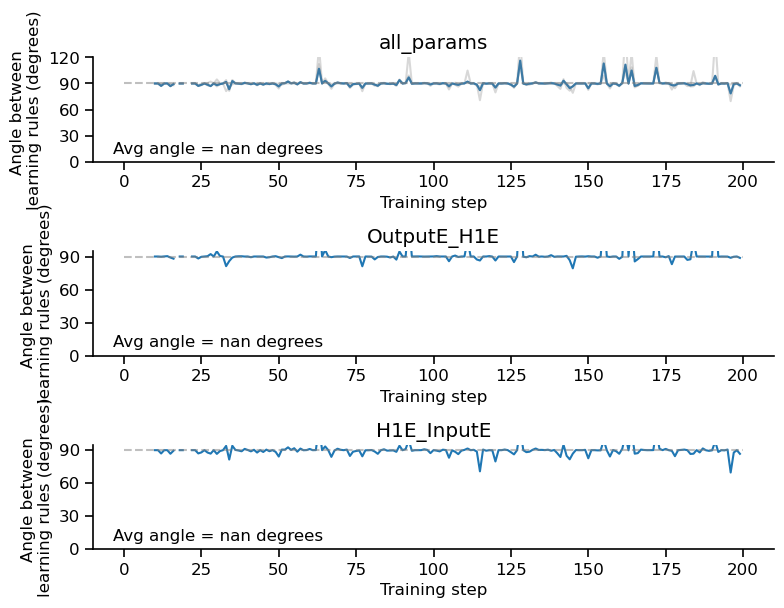

In [318]:
angles = ut.compute_dW_angles(btsp_comparison_network, plot=True)

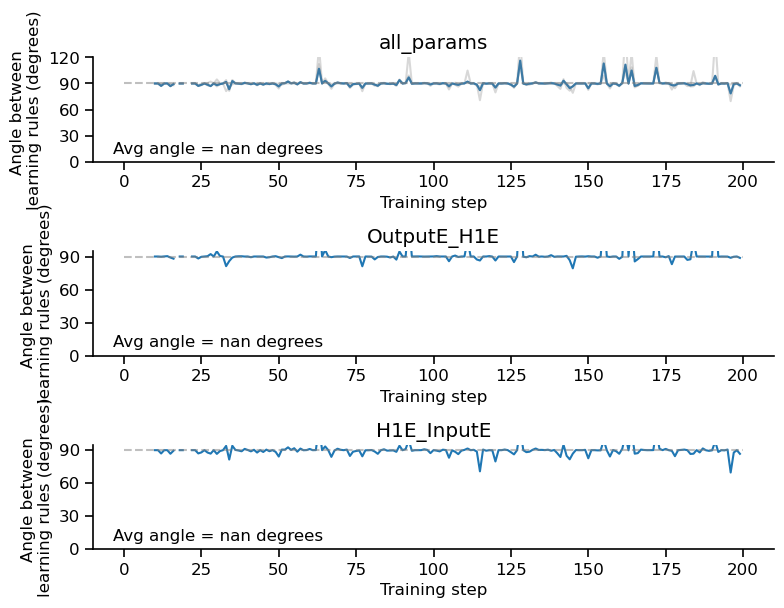

In [319]:
angles = ut.compute_dW_angles(btsp_comparison_network, plot=True, step_averaged=True)